<a href="https://colab.research.google.com/github/Ashkar077/INT345-CV-MULTILABELIMAGECLASSIFICATION/blob/main/Multi_label_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle

In [10]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [11]:
! cp kaggle.json ~/.kaggle/

In [12]:
! chmod 600 ~/.kaggle/kaggle.json

In [13]:
! kaggle datasets download -d temesgentewolde/animal-dataset-intermediate

 99% 214M/216M [00:08<00:00, 28.9MB/s]
100% 216M/216M [00:08<00:00, 27.7MB/s]


In [14]:
! unzip animal-dataset-intermediate.zip

Streaming output truncated to the last 5000 lines.
  inflating: animal_dataset_intermediate/train/farfalla/ee31b20a2cfd1c22d2524518b7444f92e37fe5d404b0144390f8c770a3e5b7_640.jpg  
  inflating: animal_dataset_intermediate/train/farfalla/ee36b10b2bf41c22d2524518b7444f92e37fe5d404b0144390f8c770a2e9b5_640.jpg  
  inflating: animal_dataset_intermediate/train/farfalla/ee36b5092df01c22d2524518b7444f92e37fe5d404b0144390f8c770a2e9b5_640.jpg  
  inflating: animal_dataset_intermediate/train/farfalla/ef31b30f2de90021d85a5854ee454296eb70e3c818b413449df6c87fa7ee_640.jpg  
  inflating: animal_dataset_intermediate/train/farfalla/ef34b00e2ef31c22d2524518b7444f92e37fe5d404b0144390f8c770a2e9b5_640.jpg  
  inflating: animal_dataset_intermediate/train/farfalla/ef3db70e29f31c22d2524518b7444f92e37fe5d404b0144390f8c770a2e9b5_640.jpg  
  inflating: animal_dataset_intermediate/train/mucca/OIP---lAIbDlHKmejDpqrXq6vAAAAA.jpeg  
  inflating: animal_dataset_intermediate/train/mucca/OIP--8_E2EnxrYh7eym5nYRTJQHaE7.jp

In [44]:
base_dir = '/content/animal_dataset_intermediate'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [45]:
print("Training images:")
for i in os.listdir(train_dir):
    print(f"----{i.split('_')[0]}: {len(os.listdir(os.path.join(train_dir, i)))} images.")

Training images:
----scoiattolo: 1676 images.
----elefante: 1299 images.
----pecora: 1638 images.
----farfalla: 1867 images.
----mucca: 1680 images.


In [46]:
print(f"Testing images: {len(os.listdir(test_dir))}")

Testing images: 910


In [47]:
def load_img(path_to_img):
    # max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    # scale = max_dim / long_dim
    scale = 1

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

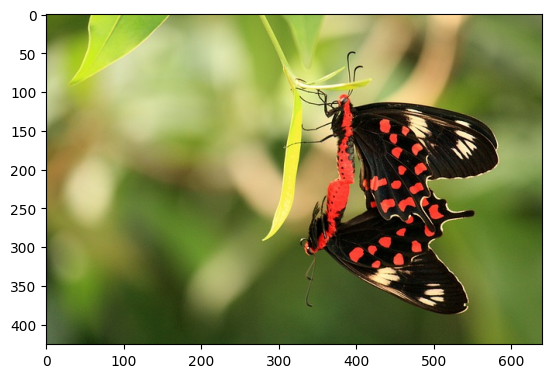

In [48]:
img = load_img(os.path.join(test_dir, os.listdir(test_dir)[0]))
imshow(img)

In [49]:
batch_size = 128
IMG_SHAPE = 160

In [50]:
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     horizontal_flip=True,
                                     rotation_range=15,
                                     zoom_range=0.1,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     shear_range=0.1,
                                     fill_mode='nearest',
                                     validation_split=0.2)


train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='sparse',
                                                     seed=42,
                                                     subset='training')

image_gen_val = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                   directory=train_dir,
                                                   shuffle=False,
                                                   target_size=(IMG_SHAPE, IMG_SHAPE),
                                                   class_mode='sparse',
                                                   seed=42,
                                                   subset='validation')

Found 6530 images belonging to 5 classes.
Found 1630 images belonging to 5 classes.


In [51]:
class_names = train_data_gen.class_indices
class_names = [k.split('_')[0] for k in class_names]
class_names

['elefante', 'farfalla', 'mucca', 'pecora', 'scoiattolo']

In [52]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

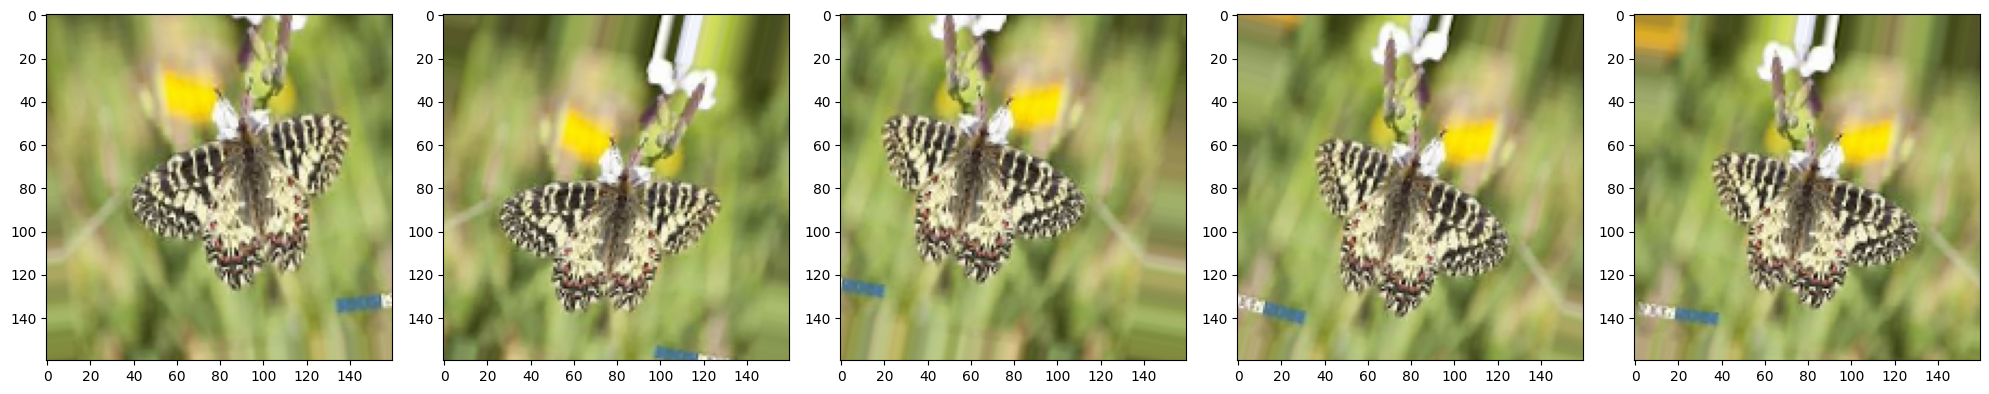

In [53]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

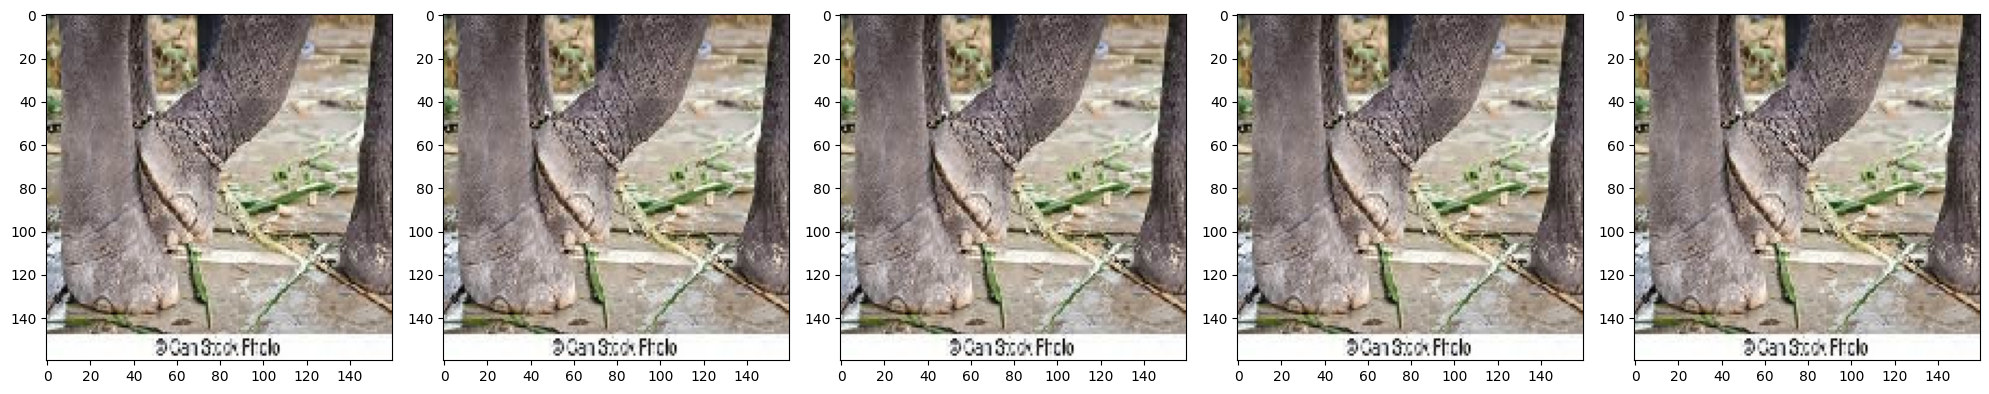

In [54]:
augmented_images_val = [val_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images_val)

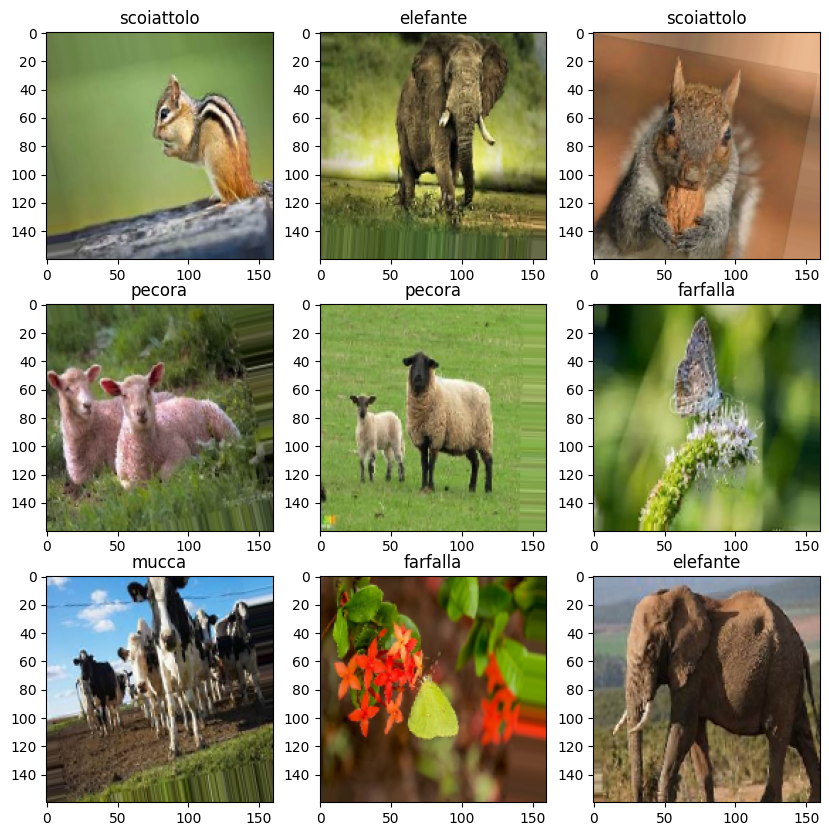

In [55]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_data_gen:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = tf.keras.preprocessing.image.array_to_img(image_batch[i])
        plt.imshow(img)
        plt.title(class_names[int(labels_batch[i])])
    break

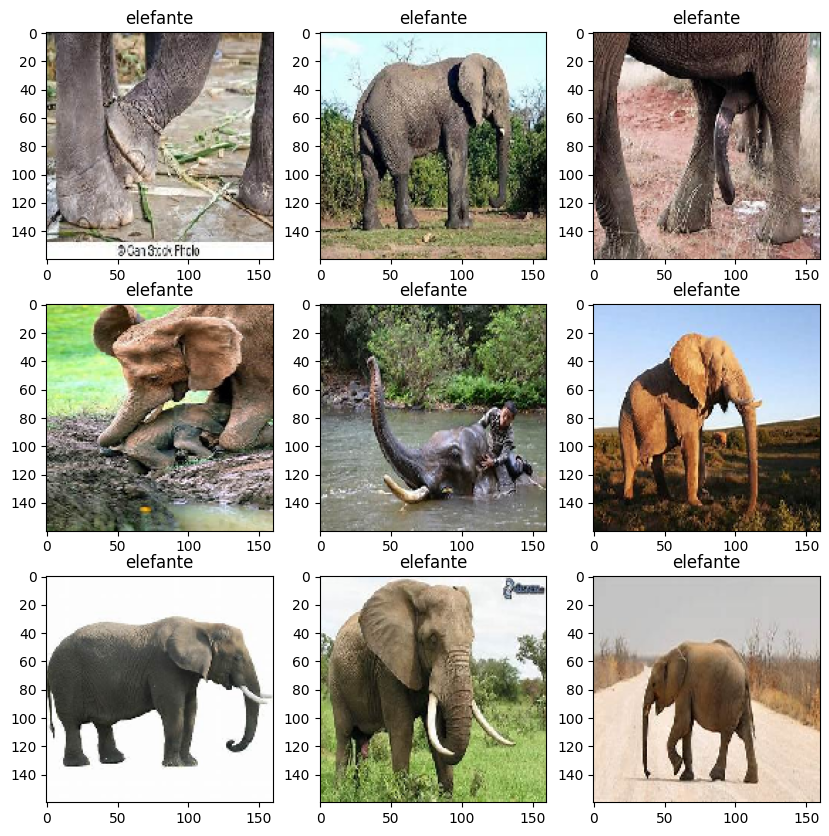

In [56]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in val_data_gen:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = tf.keras.preprocessing.image.array_to_img(image_batch[i])
        plt.imshow(img)
        plt.title(class_names[int(labels_batch[i])])
    break

In [57]:
model_mlp = tf.keras.models.Sequential([
        tf.keras.Input(shape=(IMG_SHAPE, IMG_SHAPE, 3)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2'),
        tf.keras.layers.Dense(5, activation='softmax')
])

In [58]:
initial_learning_rate = 1e-2

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [59]:
model_mlp.compile(optimizer=optimizer,
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [60]:
model_mlp.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 76800)             0         
                                                                 
 dense_8 (Dense)             (None, 32)                2457632   
                                                                 
 dense_9 (Dense)             (None, 64)                2112      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 128)               8320      
                                                                 
 dense_11 (Dense)            (None, 5)                 645       
                                                                 
Total params: 2468709 (9.42 MB)
Trainable params: 2468

In [62]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [63]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.01, verbose=1, patience=10)

In [65]:
epochs = 10

history_mlp = model_mlp.fit(
    train_data_gen,
    steps_per_epoch = train_data_gen.n // batch_size,
    validation_data = val_data_gen,
    validation_steps = val_data_gen.n // batch_size,
    epochs=epochs,
    callbacks=[tensorboard_callback, es])

Epoch 1/10
51/51 [==============================] - 48s 937ms/step - loss: 2.4091 - accuracy: 0.2293 - val_loss: 2.3891 - val_accuracy: 0.2331
Epoch 2/10
51/51 [==============================] - 47s 928ms/step - loss: 2.3886 - accuracy: 0.2424 - val_loss: 2.3774 - val_accuracy: 0.2806
Epoch 3/10
51/51 [==============================] - 49s 956ms/step - loss: 2.3660 - accuracy: 0.2607 - val_loss: 2.3403 - val_accuracy: 0.2428
Epoch 4/10
51/51 [==============================] - 48s 945ms/step - loss: 2.3450 - accuracy: 0.2535 - val_loss: 2.3213 - val_accuracy: 0.2852
Epoch 5/10
51/51 [==============================] - 46s 907ms/step - loss: 2.3192 - accuracy: 0.2577 - val_loss: 2.3092 - val_accuracy: 0.2741
Epoch 6/10
51/51 [==============================] - 48s 942ms/step - loss: 2.2983 - accuracy: 0.2680 - val_loss: 2.2818 - val_accuracy: 0.2780
Epoch 7/10
51/51 [==============================] - 48s 941ms/step - loss: 2.2758 - accuracy: 0.2715 - val_loss: 2.2536 - val_accuracy: 0.3132

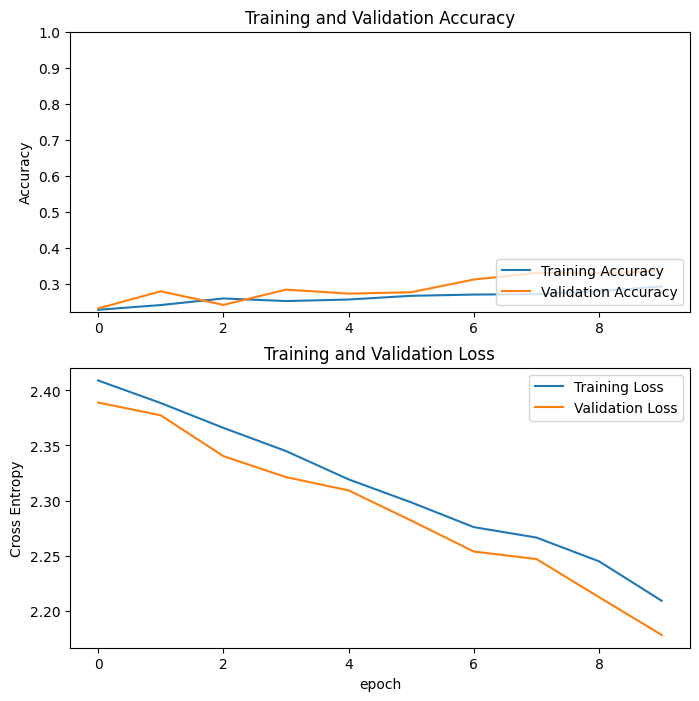

In [68]:
acc = history_mlp.history['accuracy']
val_acc = history_mlp.history['val_accuracy']

loss = history_mlp.history['loss']
val_loss = history_mlp.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [69]:
model_cnn = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE,3)),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation = 'relu', kernel_regularizer='l2'),
        tf.keras.layers.Dense(256, activation = 'relu', kernel_regularizer='l2'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

In [70]:
optimizer = tf.keras.optimizers.Adam()

In [71]:
model_cnn.compile(optimizer=optimizer,
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [72]:
model_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 158, 158, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 79, 79, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 38, 38, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 36, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 128)      

In [73]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='max', factor=0.1, patience=5, min_lr=1e-6, verbose=1)

In [74]:
log_dir_cnn = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [75]:
epochs = 10

history_cnn = model_cnn.fit(
    train_data_gen,
    steps_per_epoch = train_data_gen.n // batch_size,
    validation_data = val_data_gen,
    validation_steps = val_data_gen.n // batch_size,
    epochs=epochs,
    callbacks=[tensorboard_callback, reduce_lr, es])

Epoch 1/10
51/51 [==============================] - 55s 919ms/step - loss: 4.4643 - accuracy: 0.3565 - val_loss: 1.9585 - val_accuracy: 0.4492 - lr: 0.0010
Epoch 2/10
51/51 [==============================] - 49s 950ms/step - loss: 1.6342 - accuracy: 0.4681 - val_loss: 1.3690 - val_accuracy: 0.4980 - lr: 0.0010
Epoch 3/10
51/51 [==============================] - 49s 952ms/step - loss: 1.3728 - accuracy: 0.5034 - val_loss: 1.4699 - val_accuracy: 0.4928 - lr: 0.0010
Epoch 4/10
51/51 [==============================] - 49s 955ms/step - loss: 1.3804 - accuracy: 0.5222 - val_loss: 1.4280 - val_accuracy: 0.4935 - lr: 0.0010
Epoch 5/10
51/51 [==============================] - 48s 940ms/step - loss: 1.2029 - accuracy: 0.5728 - val_loss: 1.1622 - val_accuracy: 0.5651 - lr: 0.0010
Epoch 6/10
51/51 [==============================] - ETA: 0s - loss: 1.2939 - accuracy: 0.5319
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
51/51 [==============================] - 47s 924m

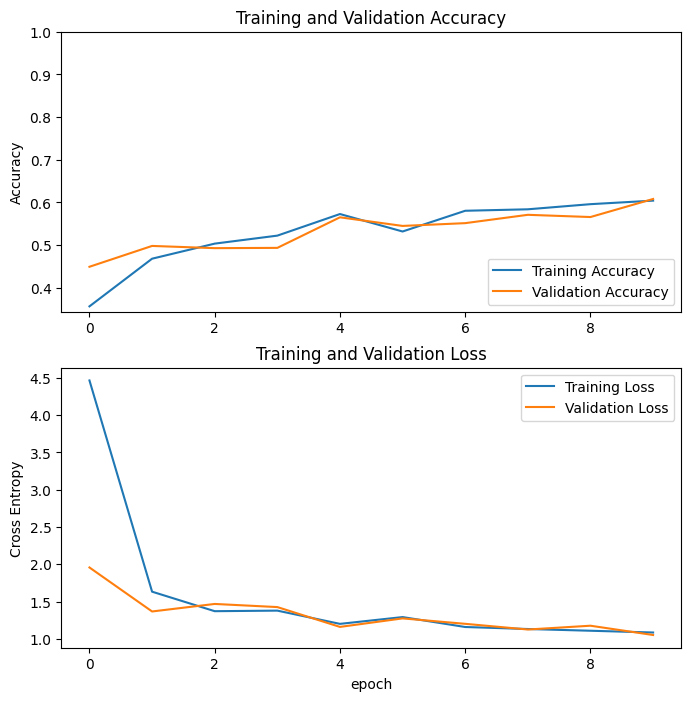

In [76]:
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']

loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [80]:
import pandas as pd
test_data = pd.read_csv(base_dir + "/Testing_set_animals.csv")
len(test_data)

910

In [81]:
for i in range(len(test_data)):
    img_name = test_data.filename[i]
    img_path = os.path.join(test_dir, img_name)
    image = keras.preprocessing.image.load_img(img_path, target_size=(IMG_SHAPE, IMG_SHAPE))
    img_array = keras.preprocessing.image.img_to_array(image)
    img_array /= 255.0
    img_array = tf.expand_dims(img_array, 0)
    prediction = model_mlp.predict(img_array)
    test_data.target[i] = class_names[prediction.argmax()]
test_data.head()

1/1 [==============================] - 0s 18ms/step


<ipython-input-81-eeaa07a92c78>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.target[i] = class_names[prediction.argmax()]


1/1 [==============================] - 0s 20ms/step


filename    target
0  e030b20928e90021d85a5854ee454296eb70e3c818b413...  farfalla
1  e030b20929e90021d85a5854ee454296eb70e3c818b413...  farfalla
2  e030b2092be90021d85a5854ee454296eb70e3c818b413...  farfalla
3  e030b2092ce90021d85a5854ee454296eb70e3c818b413...  farfalla
4  e030b2092de90021d85a5854ee454296eb70e3c818b413...  farfalla

In [85]:
!mkdir results
test_data.to_csv('results/result_mlp.csv')

In [88]:
for i in range(len(test_data)):
    img_name = test_data.filename[i]
    img_path = os.path.join(test_dir, img_name)
    image = keras.preprocessing.image.load_img(img_path, target_size=(IMG_SHAPE, IMG_SHAPE))
    img_array = keras.preprocessing.image.img_to_array(image)
    img_array /= 255.0
    img_array = tf.expand_dims(img_array, 0)
    prediction = model_cnn.predict(img_array)
    test_data.target[i] = class_names[prediction.argmax()]
test_data.head()

1/1 [==============================] - 0s 18ms/step


filename    target
0  e030b20928e90021d85a5854ee454296eb70e3c818b413...    pecora
1  e030b20929e90021d85a5854ee454296eb70e3c818b413...  farfalla
2  e030b2092be90021d85a5854ee454296eb70e3c818b413...  farfalla
3  e030b2092ce90021d85a5854ee454296eb70e3c818b413...  farfalla
4  e030b2092de90021d85a5854ee454296eb70e3c818b413...  farfalla

In [89]:
test_data.to_csv('results/result_cnn.csv')

In [91]:
INPUT_SHAPE = (IMG_SHAPE, IMG_SHAPE) + (3,)

In [92]:
base_model = tf.keras.applications.MobileNetV2(input_shape=INPUT_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


In [93]:
image_batch, label_batch = next(iter(train_data_gen))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(128, 5, 5, 1280)


In [94]:
base_model.trainable = False

In [95]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [96]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
prediction_layer = tf.keras.layers.Dense(len(class_names))
prediction_batch = prediction_layer(feature_batch_average)

In [97]:
inputs = tf.keras.Input(shape=INPUT_SHAPE)
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
transfer_model = tf.keras.Model(inputs, outputs)

In [99]:
base_learning_rate = 0.0001
transfer_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [100]:
transfer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout_8 (Dropout)         (None, 1280)              0         
                                                                 
 dense_15 (Dense)            (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02

In [101]:
initial_epochs = 10

history_transfer = transfer_model.fit(train_data_gen,
                    epochs=initial_epochs,
                    validation_data=val_data_gen)

Epoch 1/10
52/52 [==============================] - 49s 892ms/step - loss: 1.6475 - accuracy: 0.3530 - val_loss: 1.1833 - val_accuracy: 0.5595
Epoch 2/10
52/52 [==============================] - 46s 875ms/step - loss: 1.1011 - accuracy: 0.5845 - val_loss: 0.7952 - val_accuracy: 0.7546
Epoch 3/10
52/52 [==============================] - 45s 872ms/step - loss: 0.7774 - accuracy: 0.7315 - val_loss: 0.5874 - val_accuracy: 0.8301
Epoch 4/10
52/52 [==============================] - 45s 874ms/step - loss: 0.6093 - accuracy: 0.8005 - val_loss: 0.4697 - val_accuracy: 0.8669
Epoch 5/10
52/52 [==============================] - 45s 861ms/step - loss: 0.5141 - accuracy: 0.8338 - val_loss: 0.4019 - val_accuracy: 0.8816
Epoch 6/10
52/52 [==============================] - 46s 887ms/step - loss: 0.4409 - accuracy: 0.8678 - val_loss: 0.3498 - val_accuracy: 0.9006
Epoch 7/10
52/52 [==============================] - 47s 911ms/step - loss: 0.3999 - accuracy: 0.8727 - val_loss: 0.3168 - val_accuracy: 0.9061

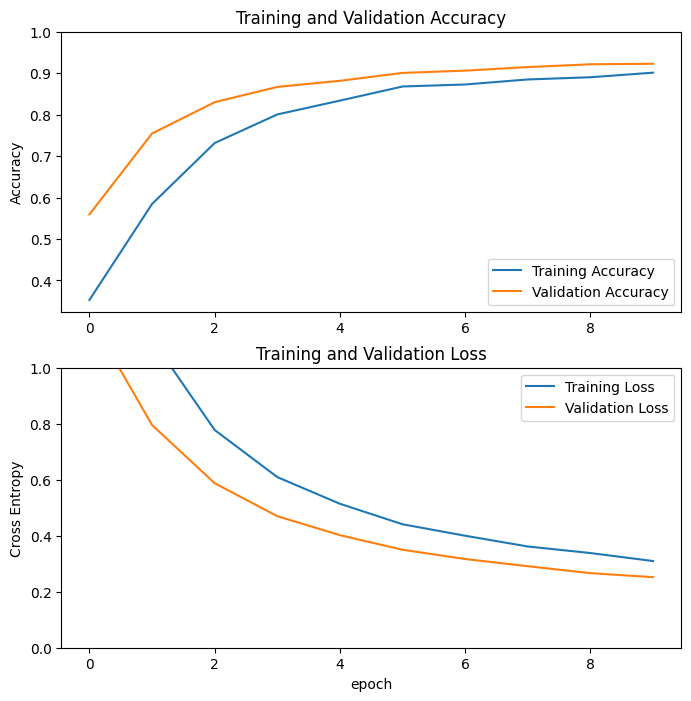

In [102]:
acc = history_transfer.history['accuracy']
val_acc = history_transfer.history['val_accuracy']

loss = history_transfer.history['loss']
val_loss = history_transfer.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [103]:
transfer_model.save('models/transfer_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
